# Policy gradients


In this notebook, we'll build a neural network that can learn to play games through reinforcement learning. More specifically, we'll use Q-learning to train an agent to play a game called [Cart-Pole](https://gym.openai.com/envs/CartPole-v0). In this game, a freely swinging pole is attached to a cart. The cart can move to the left and right, and the goal is to keep the pole upright as long as possible.

![Cart-Pole](assets/cart-pole.jpg)

We can simulate this game using [OpenAI Gym](https://gym.openai.com/). First, let's check out how OpenAI Gym works. Then, we'll get into training an agent to play the Cart-Pole game.

In [1]:
# In this one we should define and detect GPUs for tensorflow
# GPUs or CPU
import tensorflow as tf

# Check TensorFlow Version
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.7.1
Default GPU Device: 


>**Note:** Make sure you have OpenAI Gym cloned into the same directory with this notebook. I've included `gym` as a submodule, so you can run `git submodule --init --recursive` to pull the contents into the `gym` repo.

##### >**Note:** Make sure you have OpenAI Gym cloned. Then run this command `pip install -e gym/[all]`.

In [2]:
import gym

## Create the Cart-Pole game environment
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


We interact with the simulation through `env`. To show the simulation running, you can use `env.render()` to render one frame. Passing in an action as an integer to `env.step` will generate the next step in the simulation.  You can see how many actions are possible from `env.action_space` and to get a random action you can use `env.action_space.sample()`. This is general to all Gym games. In the Cart-Pole game, there are two possible actions, moving the cart left or right. So there are two actions we can take, encoded as 0 and 1.

Run the code below to watch the simulation run.

In [3]:
env.reset()
batch = []
for _ in range(1000):
    # env.render()
    action = env.action_space.sample()
    state, reward, done, info = env.step(action) # take a random action
    batch.append([action, state, reward, done, info])
    #print('state, action, reward, done, info:', state, action, reward, done, info)
    if done:
        env.reset()

To shut the window showing the simulation, use `env.close()`.

If you ran the simulation above, we can look at the rewards:

In [4]:
batch[0], batch[0][1].shape

([0,
  array([ 0.03020761, -0.2157501 , -0.00576536,  0.24520287]),
  1.0,
  False,
  {}],
 (4,))

In [5]:
import numpy as np
actions = np.array([each[0] for each in batch])
states = np.array([each[1] for each in batch])
rewards = np.array([each[2] for each in batch])
dones = np.array([each[3] for each in batch])
infos = np.array([each[4] for each in batch])

In [6]:
print(rewards[-20:])
print(np.array(rewards).shape, np.array(states).shape, np.array(actions).shape, np.array(dones).shape)
print(np.array(rewards).dtype, np.array(states).dtype, np.array(actions).dtype, np.array(dones).dtype)
print(np.max(np.array(actions)), np.min(np.array(actions)))
print((np.max(np.array(actions)) - np.min(np.array(actions)))+1)
print(np.max(np.array(rewards)), np.min(np.array(rewards)))
print(np.max(np.array(states)), np.min(np.array(states)))

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
(1000,) (1000, 4) (1000,) (1000,)
float64 float64 int64 bool
1 0
2
1.0 1.0
2.4834737163325626 -3.1271435970056705


In [7]:
# import numpy as np
def sigmoid(x, derivative=False):
  return x*(1-x) if derivative else 1/(1+np.exp(-x))

In [8]:
sigmoid(200/100)

0.8807970779778823

The game resets after the pole has fallen past a certain angle. For each frame while the simulation is running, it returns a reward of 1.0. The longer the game runs, the more reward we get. Then, our network's goal is to maximize the reward by keeping the pole vertical. It will do this by moving the cart to the left and the right.

## Q-Network

We train our Q-learning agent using the Bellman Equation:

$$
Q(s, a) = r + \gamma \max{Q(s', a')}
$$

where $s$ is a state, $a$ is an action, and $s'$ is the next state from state $s$ and action $a$.

Before we used this equation to learn values for a Q-_table_. However, for this game there are a huge number of states available. The state has four values: the position and velocity of the cart, and the position and velocity of the pole. These are all real-valued numbers, so ignoring floating point precisions, you practically have infinite states. Instead of using a table then, we'll replace it with a neural network that will approximate the Q-table lookup function.

<img src="assets/deep-q-learning.png" width=450px>

Now, our Q value, $Q(s, a)$ is calculated by passing in a state to the network. The output will be Q-values for each available action, with fully connected hidden layers.

<img src="assets/q-network.png" width=550px>


As I showed before, we can define our targets for training as $\hat{Q}(s,a) = r + \gamma \max{Q(s', a')}$. Then we update the weights by minimizing $(\hat{Q}(s,a) - Q(s,a))^2$. 

For this Cart-Pole game, we have four inputs, one for each value in the state, and two outputs, one for each action. To get $\hat{Q}$, we'll first choose an action, then simulate the game using that action. This will get us the next state, $s'$, and the reward. With that, we can calculate $\hat{Q}$ then pass it back into the $Q$ network to run the optimizer and update the weights.

Below is my implementation of the Q-network. I used two fully connected layers with ReLU activations. Two seems to be good enough, three might be better. Feel free to try it out.

In [53]:
# Data of the model
def model_input(state_size):
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    actions = tf.placeholder(tf.int32, [None], name='actions')
    reward = tf.placeholder(tf.float32, [], name='reward')
    return states, actions, reward

In [54]:
# Generator: Generating/prediting the actions
def generator(states, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=action_size)        
        #predictions = tf.nn.softmax(logits)

        # return actions logits
        return logits

In [68]:
def model_loss(states, actions, reward, # model input
               action_size, hidden_size): # model init
    actions_logits = generator(states=states, hidden_size=hidden_size, action_size=action_size)
    actions_labels = tf.one_hot(indices=actions, depth=action_size, dtype=actions_logits.dtype)
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=actions_logits, 
                                                                     labels=actions_labels))
    reward_prob = tf.nn.sigmoid(reward/10)
    loss *= -reward_prob
    return actions_logits, loss, reward_prob

In [69]:
def model_opt(loss, learning_rate):
    """
    Get optimization operations in order
    :param loss: Generator loss Tensor for action prediction
    :param learning_rate: Learning Rate Placeholder
    :return: A tuple of (qfunction training, generator training, discriminator training)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): # Required for batchnorm (BN)
        opt = tf.train.AdamOptimizer(learning_rate).minimize(loss, var_list=g_vars)

    return opt

In [70]:
class Model:
    def __init__(self, state_size, action_size, hidden_size, learning_rate):

        # Data of the Model: make the data available inside the framework
        self.states, self.actions, self.reward = model_input(state_size=state_size)

        # Create the Model: calculating the loss and forwad pass
        self.actions_logits, self.loss, self.reward_prob = model_loss(
            action_size=action_size, hidden_size=hidden_size, # model init parameters
            states=self.states, actions=self.actions, reward=self.reward) # model input
        
        # Update the model: backward pass and backprop
        self.opt = model_opt(loss=self.loss, learning_rate=learning_rate)

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [71]:
print('state size:{}'.format(states.shape), 
      'actions:{}'.format(actions.shape)) 
print('action size:{}'.format(np.max(actions) - np.min(actions)+1))

state size:(500, 4) actions:(500,)
action size:2


In [72]:
# Training parameters
# Network parameters
state_size = 4                 # number of units for the input state/observation -- simulation
action_size = 2                # number of units for the output actions -- simulation
hidden_size = 64               # number of units in each Q-network hidden layer -- simulation
learning_rate = 0.001          # learning rate for adam

In [73]:
# Reset/init the graph/session
graph = tf.reset_default_graph()

# Init the model
model = Model(action_size=action_size, hidden_size=hidden_size, state_size=state_size, learning_rate=learning_rate)

## Training the model

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [76]:
# Now train with experiences
saver = tf.train.Saver()
rewards_list, loss_list = [], []

# TF session for training
with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Training episodes/epochs
    for ep in range(1000):
        state = env.reset() # env first state
        batch = [] # every data batch
        total_reward = 0

        # Training steps
        #for _ in range(max_steps): # start=0, step=1, stop=max_steps/done/reward
        while True:
            action_logits = sess.run(model.actions_logits, feed_dict={model.states: np.reshape(state, [1, -1])})
            action = np.argmax(action_logits)
            batch.append([state, action])
            state, reward, done, _ = env.step(action)
            total_reward += reward
            if done is True:
                break
        
        # Training batches
        #batch = memory.buffer
        states = np.array([each[0] for each in batch])
        actions = np.array([each[1] for each in batch])
        loss, _, reward_prob = sess.run([model.loss, model.opt, model.reward_prob],
                                        feed_dict = {model.states: states, 
                                                     model.actions: actions,
                                                     model.reward: total_reward})
        print('Episode: {}'.format(ep),
              'total_reward: {}'.format(total_reward),
              'reward_prob: {:.4f}'.format(reward_prob),
              'loss: {:.4f}'.format(loss))
        rewards_list.append([ep, total_reward])
        loss_list.append([ep, loss])
        if total_reward == 500:
            break
            
    # At the end of all training episodes/epochs
    saver.save(sess, 'checkpoints/model.ckpt')

INFO:tensorflow:Restoring parameters from checkpoints/model.ckpt
Episode: 0 total_reward: 60.0 reward_prob: 0.9975 loss: -0.6889
Episode: 1 total_reward: 48.0 reward_prob: 0.9918 loss: -0.6849
Episode: 2 total_reward: 19.0 reward_prob: 0.8699 loss: -0.6020
Episode: 3 total_reward: 26.0 reward_prob: 0.9309 loss: -0.6438
Episode: 4 total_reward: 10.0 reward_prob: 0.7311 loss: -0.5057
Episode: 5 total_reward: 12.0 reward_prob: 0.7685 loss: -0.5317
Episode: 6 total_reward: 70.0 reward_prob: 0.9991 loss: -0.6903
Episode: 7 total_reward: 92.0 reward_prob: 0.9999 loss: -0.6896
Episode: 8 total_reward: 58.0 reward_prob: 0.9970 loss: -0.6889
Episode: 9 total_reward: 73.0 reward_prob: 0.9993 loss: -0.6905
Episode: 10 total_reward: 68.0 reward_prob: 0.9989 loss: -0.6904
Episode: 11 total_reward: 95.0 reward_prob: 0.9999 loss: -0.6900
Episode: 12 total_reward: 49.0 reward_prob: 0.9926 loss: -0.6858
Episode: 13 total_reward: 25.0 reward_prob: 0.9241 loss: -0.6387
Episode: 14 total_reward: 15.0 rewa

Episode: 131 total_reward: 52.0 reward_prob: 0.9945 loss: -0.6877
Episode: 132 total_reward: 11.0 reward_prob: 0.7503 loss: -0.5192
Episode: 133 total_reward: 24.0 reward_prob: 0.9168 loss: -0.6348
Episode: 134 total_reward: 10.0 reward_prob: 0.7311 loss: -0.5055
Episode: 135 total_reward: 20.0 reward_prob: 0.8808 loss: -0.6100
Episode: 136 total_reward: 28.0 reward_prob: 0.9427 loss: -0.6528
Episode: 137 total_reward: 126.0 reward_prob: 1.0000 loss: -0.6927
Episode: 138 total_reward: 210.0 reward_prob: 1.0000 loss: -0.6921
Episode: 139 total_reward: 50.0 reward_prob: 0.9933 loss: -0.6869
Episode: 140 total_reward: 10.0 reward_prob: 0.7311 loss: -0.5058
Episode: 141 total_reward: 24.0 reward_prob: 0.9168 loss: -0.6346
Episode: 142 total_reward: 19.0 reward_prob: 0.8699 loss: -0.6022
Episode: 143 total_reward: 15.0 reward_prob: 0.8176 loss: -0.5663
Episode: 144 total_reward: 35.0 reward_prob: 0.9707 loss: -0.6707
Episode: 145 total_reward: 143.0 reward_prob: 1.0000 loss: -0.6918
Episode

Episode: 266 total_reward: 68.0 reward_prob: 0.9989 loss: -0.6910
Episode: 267 total_reward: 13.0 reward_prob: 0.7858 loss: -0.5440
Episode: 268 total_reward: 10.0 reward_prob: 0.7311 loss: -0.5061
Episode: 269 total_reward: 11.0 reward_prob: 0.7503 loss: -0.5191
Episode: 270 total_reward: 24.0 reward_prob: 0.9168 loss: -0.6342
Episode: 271 total_reward: 20.0 reward_prob: 0.8808 loss: -0.6093
Episode: 272 total_reward: 38.0 reward_prob: 0.9781 loss: -0.6762
Episode: 273 total_reward: 38.0 reward_prob: 0.9781 loss: -0.6764
Episode: 274 total_reward: 39.0 reward_prob: 0.9802 loss: -0.6781
Episode: 275 total_reward: 129.0 reward_prob: 1.0000 loss: -0.6919
Episode: 276 total_reward: 78.0 reward_prob: 0.9996 loss: -0.6915
Episode: 277 total_reward: 368.0 reward_prob: 1.0000 loss: -0.6916
Episode: 278 total_reward: 88.0 reward_prob: 0.9998 loss: -0.6919
Episode: 279 total_reward: 52.0 reward_prob: 0.9945 loss: -0.6880
Episode: 280 total_reward: 54.0 reward_prob: 0.9955 loss: -0.6884
Episode:

Episode: 391 total_reward: 175.0 reward_prob: 1.0000 loss: -0.6920
Episode: 392 total_reward: 113.0 reward_prob: 1.0000 loss: -0.6915
Episode: 393 total_reward: 350.0 reward_prob: 1.0000 loss: -0.6917
Episode: 394 total_reward: 65.0 reward_prob: 0.9985 loss: -0.6905
Episode: 395 total_reward: 13.0 reward_prob: 0.7858 loss: -0.5440
Episode: 396 total_reward: 16.0 reward_prob: 0.8320 loss: -0.5754
Episode: 397 total_reward: 13.0 reward_prob: 0.7858 loss: -0.5437
Episode: 398 total_reward: 10.0 reward_prob: 0.7311 loss: -0.5051
Episode: 399 total_reward: 13.0 reward_prob: 0.7858 loss: -0.5419
Episode: 400 total_reward: 15.0 reward_prob: 0.8176 loss: -0.5639
Episode: 401 total_reward: 14.0 reward_prob: 0.8022 loss: -0.5527
Episode: 402 total_reward: 14.0 reward_prob: 0.8022 loss: -0.5527
Episode: 403 total_reward: 13.0 reward_prob: 0.7858 loss: -0.5411
Episode: 404 total_reward: 10.0 reward_prob: 0.7311 loss: -0.5035
Episode: 405 total_reward: 12.0 reward_prob: 0.7685 loss: -0.5288
Episode

Episode: 520 total_reward: 66.0 reward_prob: 0.9986 loss: -0.6905
Episode: 521 total_reward: 500.0 reward_prob: 1.0000 loss: -0.6921


# Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [77]:
import matplotlib.pyplot as plt
%matplotlib inline

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

Text(0,0.5,'Total rewards')

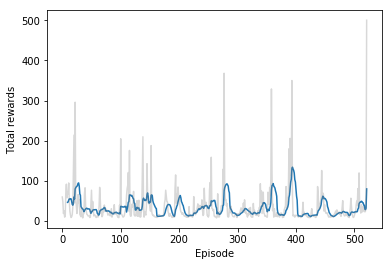

In [78]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Batch losses')

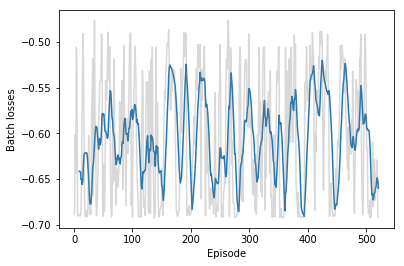

In [79]:
eps, arr = np.array(loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Batch losses')

## Testing

Let's checkout how our trained agent plays the game.

In [80]:
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

with tf.Session() as sess:
    #sess.run(tf.global_variables_initializer())
    saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Episodes/epochs
    for _ in range(1):
        state = env.reset()
        total_reward = 0

        # Steps/batches
        #for _ in range(111111111111111111):
        while True:
            env.render()
            action_logits = sess.run(model.actions_logits, feed_dict={model.states: np.reshape(state, [1, -1])})
            action = np.argmax(action_logits)
            state, reward, done, _ = env.step(action)
            total_reward += reward
            if done:
                break
                
        # Closing the env
        print('total_reward: {:.2f}'.format(total_reward))
        env.close()

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
INFO:tensorflow:Restoring parameters from checkpoints/model.ckpt


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


total_reward: 500.00


## Extending this

So, Cart-Pole is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders. Instead of a state like we're using here though, you'd want to use convolutional layers to get the state from the screen images.

![Deep Q-Learning Atari](assets/atari-network.png)

I'll leave it as a challenge for you to use deep Q-learning to train an agent to play Atari games. Here's the original paper which will get you started: http://www.davidqiu.com:8888/research/nature14236.pdf.